In [1]:
from torch.utils.data import Dataset
import torch
import glob
import pandas as pd
from datetime import datetime
import os
import math
from tqdm import tqdm
import numpy as np

from scipy import signal

/home/yhbedoya/VirtualEnvs/SHMmae_venv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
start_time, end_time = "05/12/2021 00:00", "05/12/2021 00:30"
path = '/home/yhbedoya/Repositories/SHM-MAE/traffic/20211205/'

print(f'reading CSV files')
start = datetime.strptime(start_time, '%d/%m/%Y %H:%M')
end = datetime.strptime(end_time, '%d/%m/%Y %H:%M')

ldf = list()
for p in tqdm(glob.glob(path + "*.csv")):
    name = os.path.split(p)[-1]
    nstr = datetime.strptime(name, 'traffic_%Y%m%dH%H%M%S.csv')
    if start <= nstr < end:
        df_tmp = pd.read_csv(p)
        c_drop = set(df_tmp.columns) - set(["sens_pos", "z", "ts"])
        if len(c_drop) > 0:
            df_tmp.drop(columns=list(c_drop), inplace=True)
        ldf.append(df_tmp)
df = pd.concat(ldf).sort_values(by=['sens_pos', 'ts'])
df.reset_index(inplace=True, drop=True)

#df = df[df['sens_pos'].isin(self.sensors)]
df['ts'] = pd.to_datetime(df['ts'], unit='ms')
data = df[df["sens_pos"]== "C1.1.1"]

reading CSV files


100%|██████████| 1450/1450 [00:11<00:00, 124.57it/s]


In [3]:
data["z2"] = data["z"]-np.mean(data["z"])
data

/home/yhbedoya/VirtualEnvs/SHMmae_venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


sens_pos         z                      ts        z2
0        C1.1.1 -0.988022 2021-12-05 00:00:00.311  0.000391
1        C1.1.1 -0.988098 2021-12-05 00:00:00.321  0.000314
2        C1.1.1 -0.988403 2021-12-05 00:00:00.331  0.000009
3        C1.1.1 -0.987945 2021-12-05 00:00:00.341  0.000467
4        C1.1.1 -0.988479 2021-12-05 00:00:00.351 -0.000067
...         ...       ...                     ...       ...
179964   C1.1.1 -0.989395 2021-12-05 00:30:00.036 -0.000983
179965   C1.1.1 -0.988556 2021-12-05 00:30:00.046 -0.000143
179966   C1.1.1 -0.988785 2021-12-05 00:30:00.056 -0.000372
179967   C1.1.1 -0.988174 2021-12-05 00:30:00.066  0.000238
179968   C1.1.1 -0.988556 2021-12-05 00:30:00.076 -0.000143

[179969 rows x 4 columns]

In [4]:
import matplotlib.pyplot as plt

plt.plot(data["z2"])
plt.show()

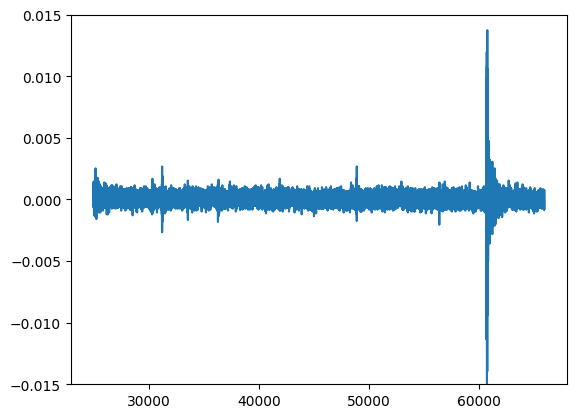

In [96]:
slice = data[(data["ts"]>= "2021-12-05 00:04:10") & (data["ts"]<= "2021-12-05 00:11:00")]

plt.plot(slice["z2"])
plt.ylim(-0.015, 0.015)
plt.show()

In [100]:
vars = []
dates = []
for i in range(4, len(slice)):
    vars.append(np.var(np.array(slice["z2"][(i-4):i])))
    dates.append(slice["ts"].iloc[i])

In [116]:
threshold = 5e-7
outliers = []
for i in range(len(vars)):
    if vars[i] > threshold:
        outliers.append(i)

groups = {}
times = {}
group = []
last = 0
indexGroup = 0
timeStart = dates[outliers[0]]
for outlier in outliers:
    if ((outlier - last) < 25) or flag:
        group.append(outlier)
        flag = False
        timeEnd = dates[outlier]
    else:
        groups[indexGroup] = group
        if len(group)>10:
            times[indexGroup] = (timeStart, timeEnd) #(group, timeStart, timeEnd)
        indexGroup += 1
        group = [outlier,]
        flag = True
        timeStart = dates[outlier]
        timeEnd = dates[outlier]
    last = outlier


In [117]:
times

{2: (Timestamp('2021-12-05 00:04:11.361000'),
  Timestamp('2021-12-05 00:04:12.051000')),
 3: (Timestamp('2021-12-05 00:04:12.361000'),
  Timestamp('2021-12-05 00:04:12.861000')),
 11: (Timestamp('2021-12-05 00:05:12.231000'),
  Timestamp('2021-12-05 00:05:13.001000')),
 15: (Timestamp('2021-12-05 00:05:54.981000'),
  Timestamp('2021-12-05 00:06:03.821000')),
 20: (Timestamp('2021-12-05 00:08:09.031000'),
  Timestamp('2021-12-05 00:08:09.571000')),
 25: (Timestamp('2021-12-05 00:10:06.641000'),
  Timestamp('2021-12-05 00:10:14.921000')),
 26: (Timestamp('2021-12-05 00:10:15.651000'),
  Timestamp('2021-12-05 00:10:16.851000')),
 29: (Timestamp('2021-12-05 00:10:18.371000'),
  Timestamp('2021-12-05 00:10:18.781000'))}

(0.0, 5.0)

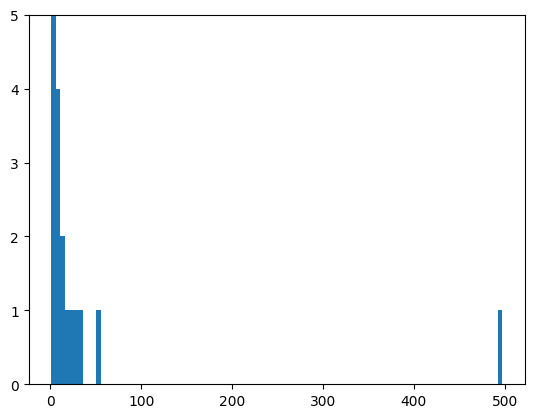

In [118]:
lens = []
for k, v in groups.items():
    if len(v) > 0:
        lens.append(len(v))

plt.hist(lens, bins=100)
plt.ylim(0, 5)

In [24]:
from datetime import datetime
from datetime import timedelta

datetime_str = '2021-12-05 00:03:00'

datetime_object = datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S')

print(type(datetime_object))
print(datetime_object)  # printed in default format


<class 'datetime.datetime'>
2021-12-05 00:03:00


In [25]:
print(datetime_object.strftime('%Y-%m-%d %H:%M:%S'))

2021-12-05 00:03:00


In [26]:
from scipy import signal

def printPSD(window, timestamp):

    f, Pxx_den = signal.welch(window, 100, nperseg=100)

    plt.semilogy(f, Pxx_den)
    plt.title(f'PSD, Time: {timestamp}')
    plt.ylim([0.5e-10, 0.5e-5])
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.show()

2021-12-05 00:03:00
2021-12-05 00:03:01


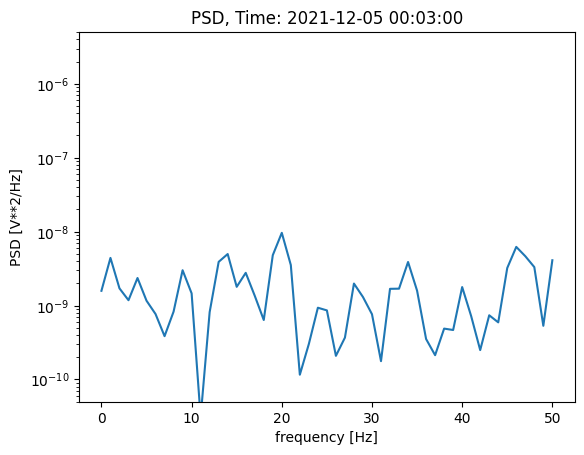

2021-12-05 00:03:01
2021-12-05 00:03:02


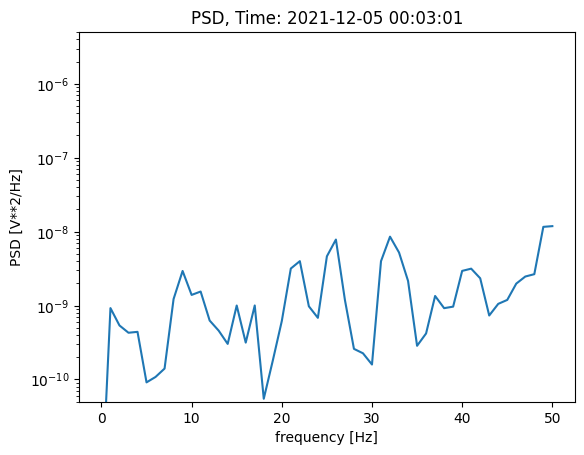

2021-12-05 00:03:02
2021-12-05 00:03:03


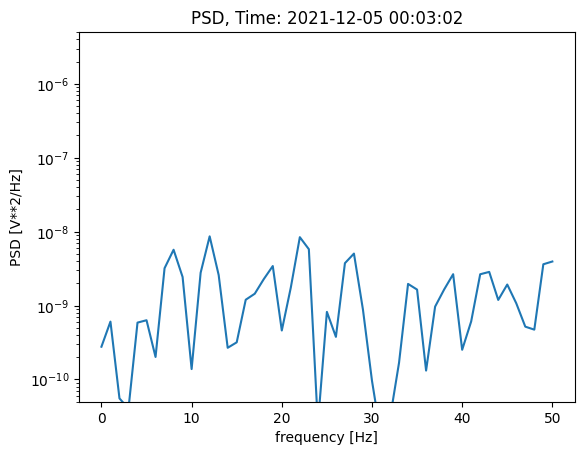

2021-12-05 00:03:03
2021-12-05 00:03:04


2021-12-05 00:03:04
2021-12-05 00:03:05


2021-12-05 00:03:05
2021-12-05 00:03:06


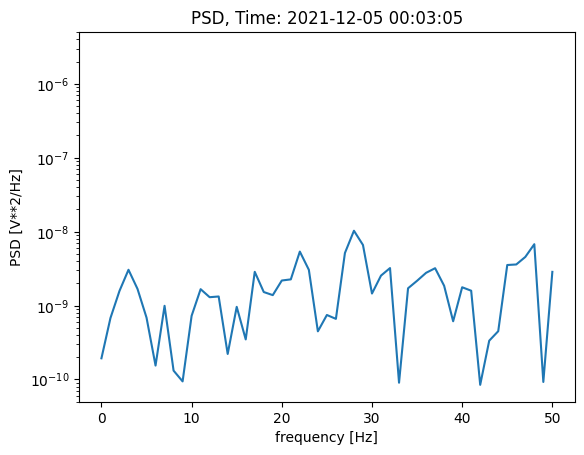

2021-12-05 00:03:06
2021-12-05 00:03:07


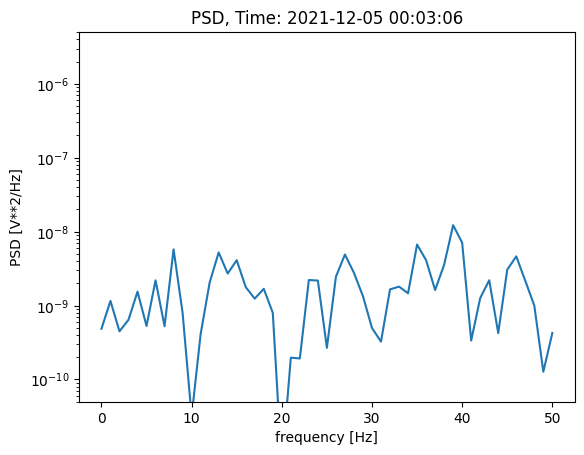

2021-12-05 00:03:07
2021-12-05 00:03:08


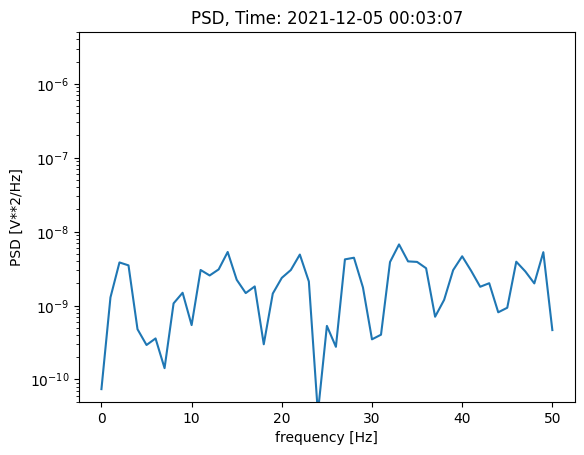

2021-12-05 00:03:08
2021-12-05 00:03:09


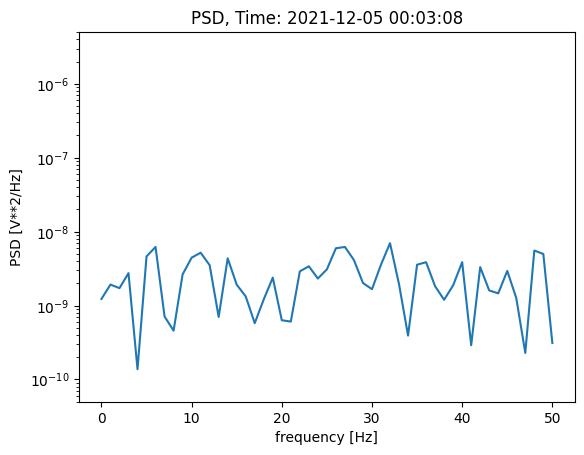

2021-12-05 00:03:09
2021-12-05 00:03:10


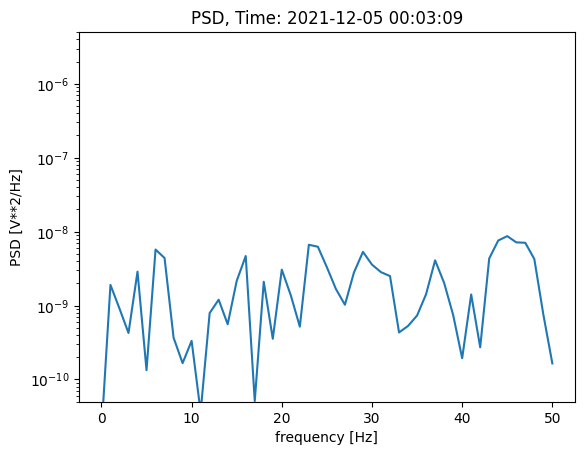

2021-12-05 00:03:10
2021-12-05 00:03:11


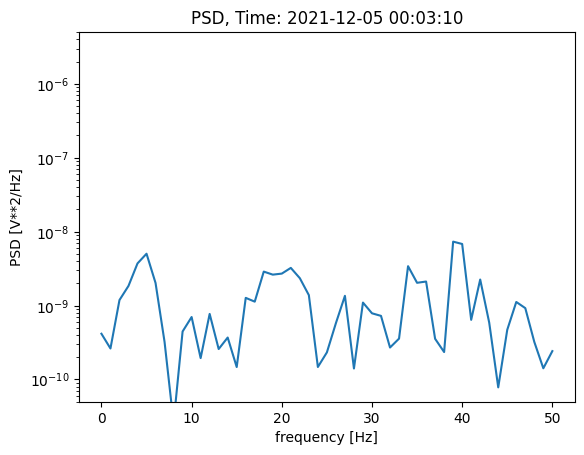

2021-12-05 00:03:11
2021-12-05 00:03:12


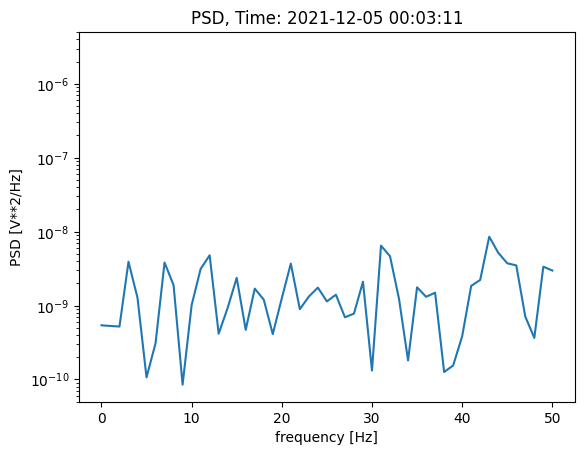

2021-12-05 00:03:12
2021-12-05 00:03:13


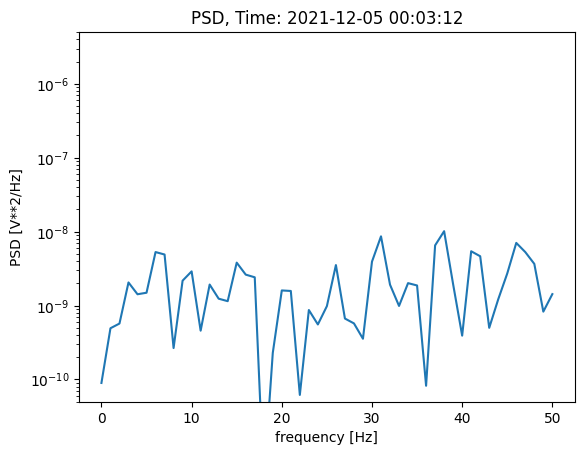

2021-12-05 00:03:13
2021-12-05 00:03:14


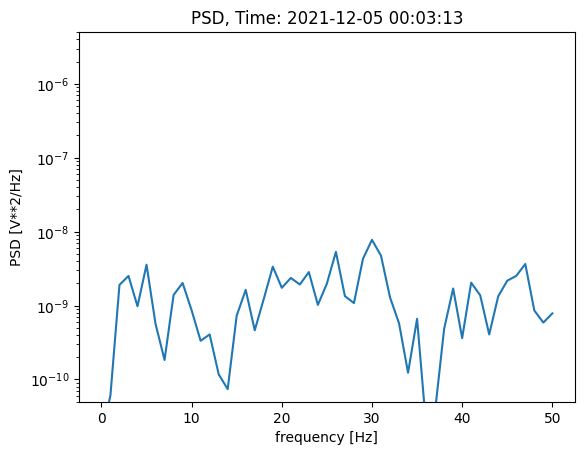

2021-12-05 00:03:14
2021-12-05 00:03:15


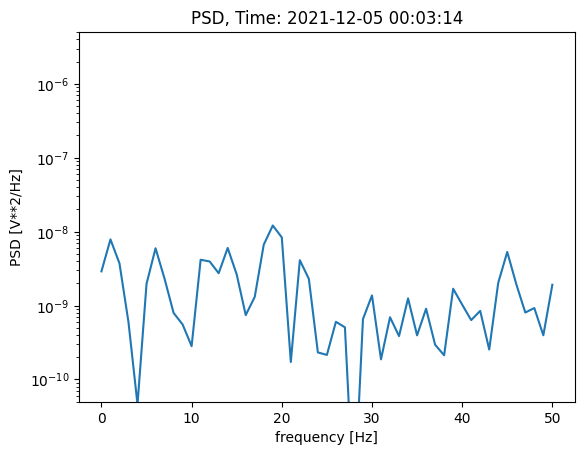

2021-12-05 00:03:15
2021-12-05 00:03:16


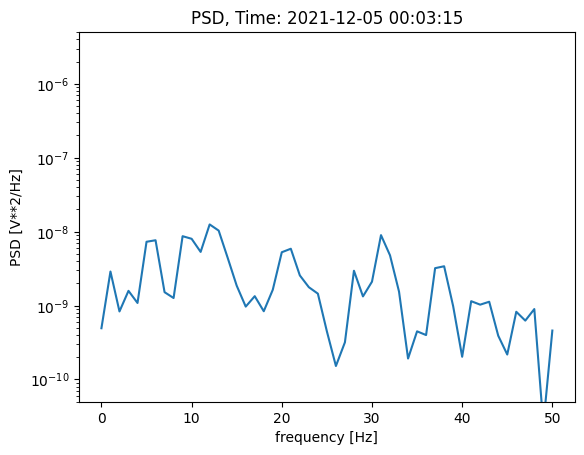

2021-12-05 00:03:16
2021-12-05 00:03:17


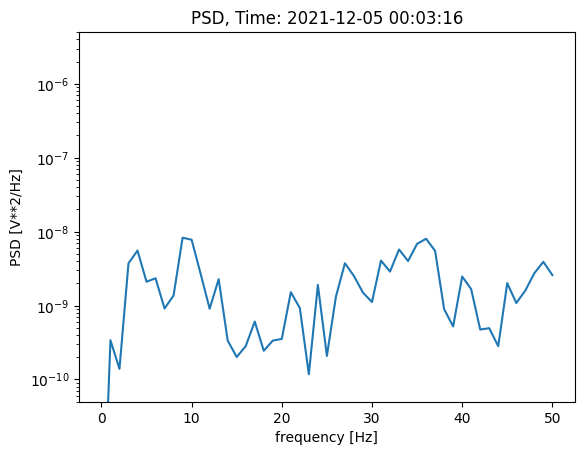

2021-12-05 00:03:17
2021-12-05 00:03:18


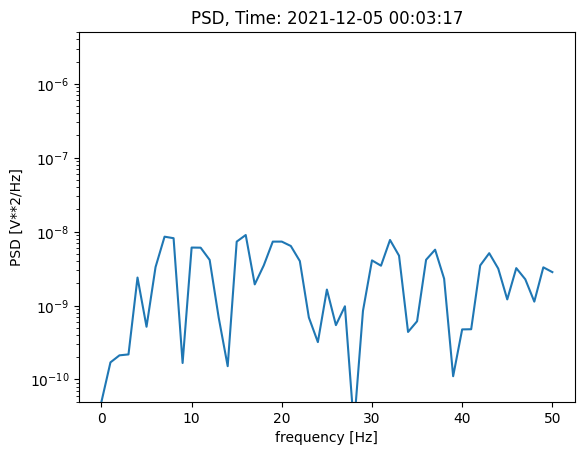

2021-12-05 00:03:18
2021-12-05 00:03:19


2021-12-05 00:03:19
2021-12-05 00:03:20


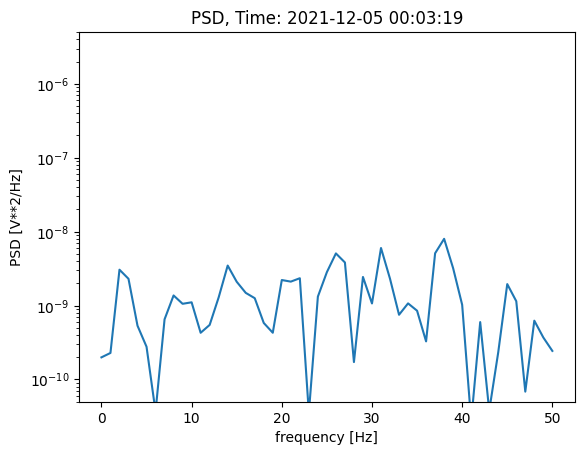

2021-12-05 00:03:20
2021-12-05 00:03:21


2021-12-05 00:03:21
2021-12-05 00:03:22


2021-12-05 00:03:22
2021-12-05 00:03:23


2021-12-05 00:03:23
2021-12-05 00:03:24


2021-12-05 00:03:24
2021-12-05 00:03:25


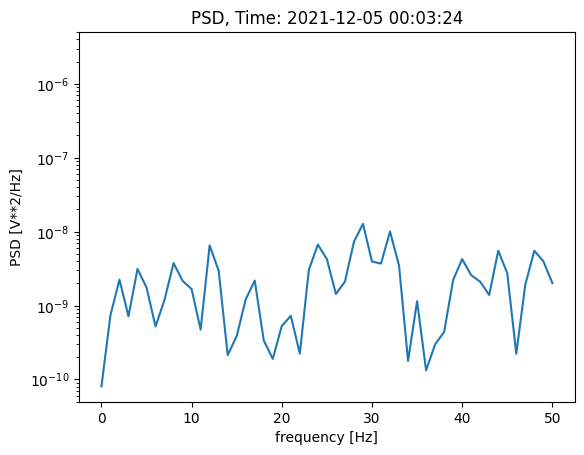

2021-12-05 00:03:25
2021-12-05 00:03:26


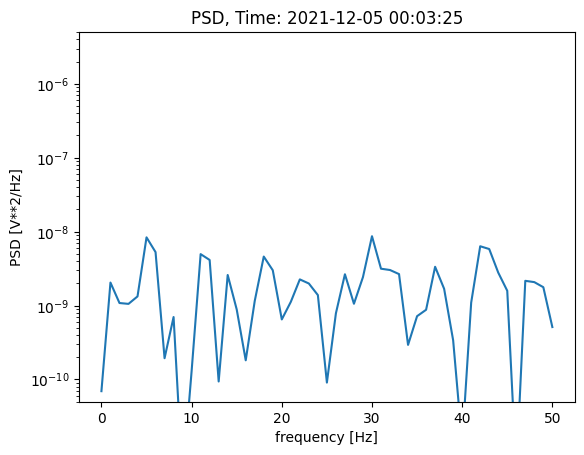

2021-12-05 00:03:26
2021-12-05 00:03:27


2021-12-05 00:03:27
2021-12-05 00:03:28


2021-12-05 00:03:28
2021-12-05 00:03:29


2021-12-05 00:03:29
2021-12-05 00:03:30


2021-12-05 00:03:30
2021-12-05 00:03:31


2021-12-05 00:03:31
2021-12-05 00:03:32


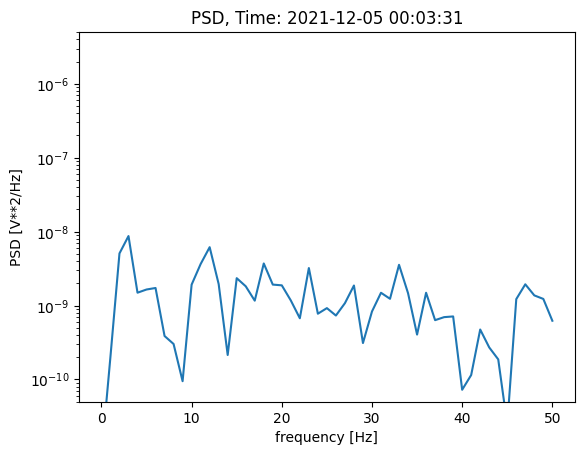

2021-12-05 00:03:32
2021-12-05 00:03:33


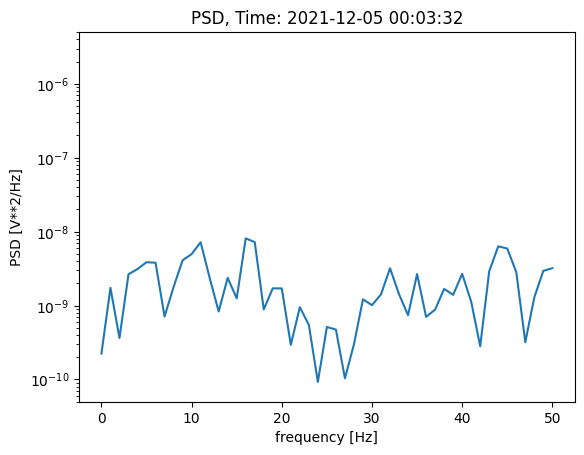

2021-12-05 00:03:33
2021-12-05 00:03:34


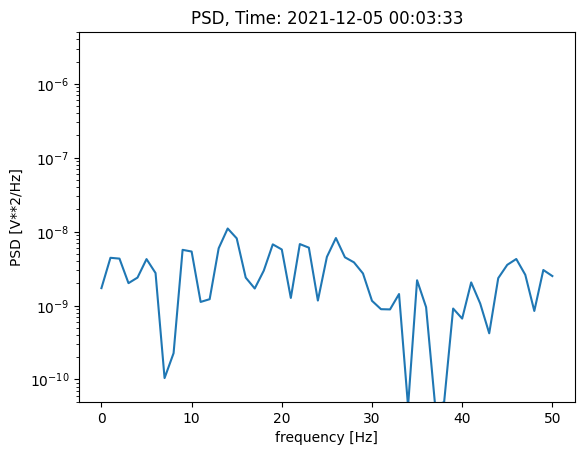

2021-12-05 00:03:34
2021-12-05 00:03:35


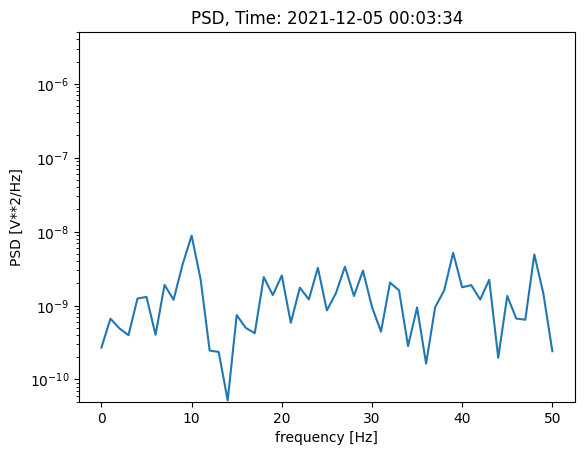

2021-12-05 00:03:35
2021-12-05 00:03:36


2021-12-05 00:03:36
2021-12-05 00:03:37


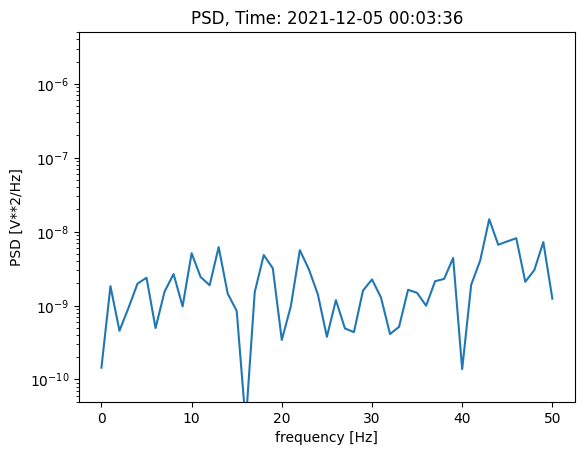

2021-12-05 00:03:37
2021-12-05 00:03:38


2021-12-05 00:03:38
2021-12-05 00:03:39


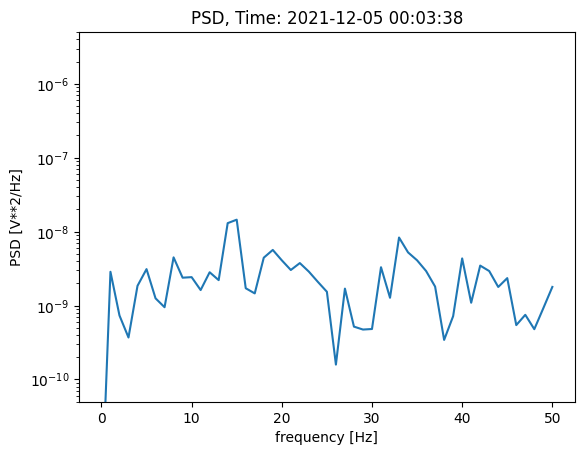

2021-12-05 00:03:39
2021-12-05 00:03:40


2021-12-05 00:03:40
2021-12-05 00:03:41


2021-12-05 00:03:41
2021-12-05 00:03:42


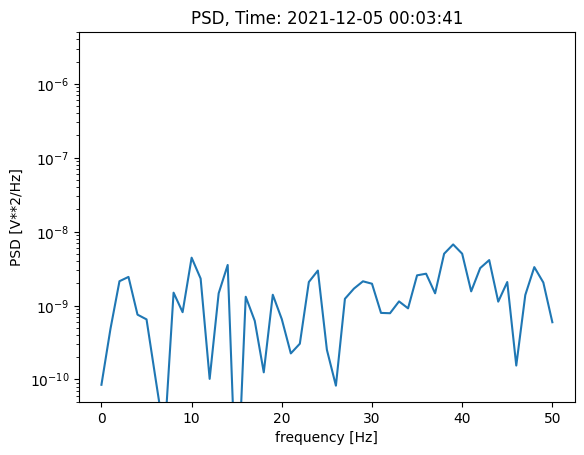

2021-12-05 00:03:42
2021-12-05 00:03:43


2021-12-05 00:03:43
2021-12-05 00:03:44


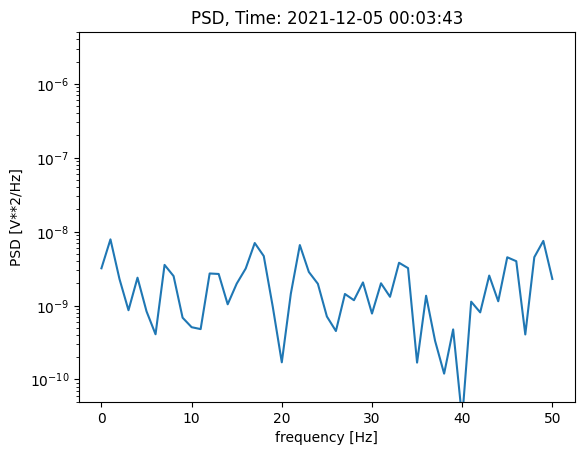

2021-12-05 00:03:44
2021-12-05 00:03:45


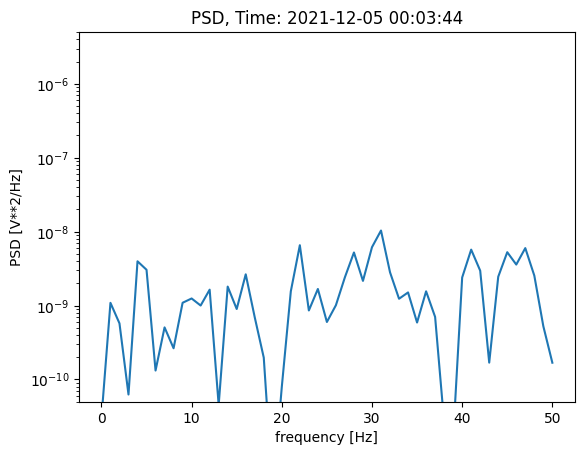

2021-12-05 00:03:45
2021-12-05 00:03:46


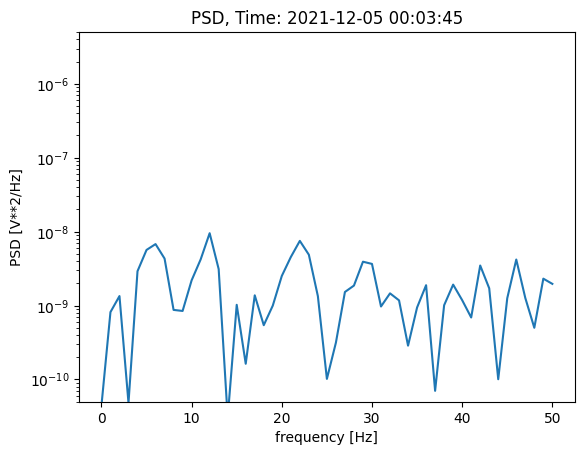

2021-12-05 00:03:46
2021-12-05 00:03:47


2021-12-05 00:03:47
2021-12-05 00:03:48


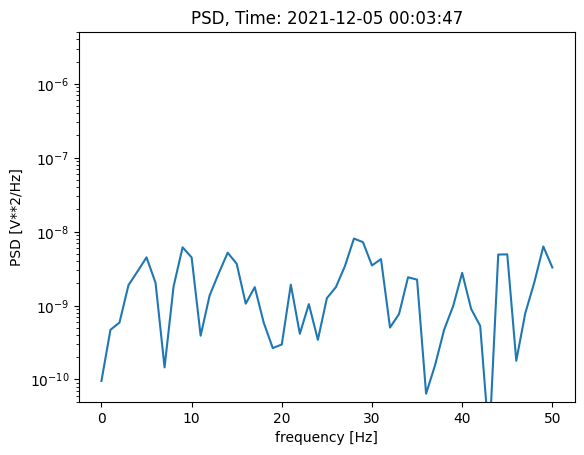

2021-12-05 00:03:48
2021-12-05 00:03:49


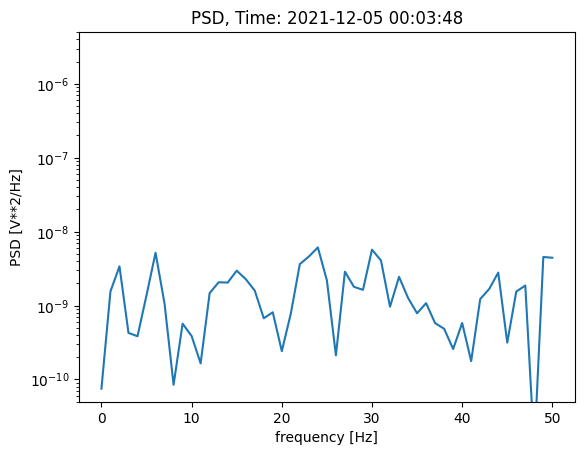

2021-12-05 00:03:49
2021-12-05 00:03:50


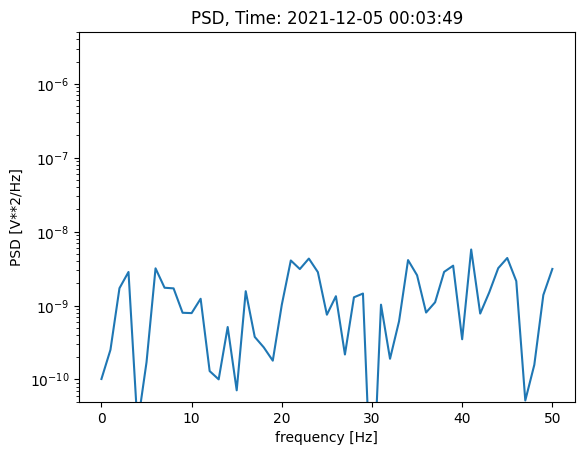

2021-12-05 00:03:50
2021-12-05 00:03:51


2021-12-05 00:03:51
2021-12-05 00:03:52


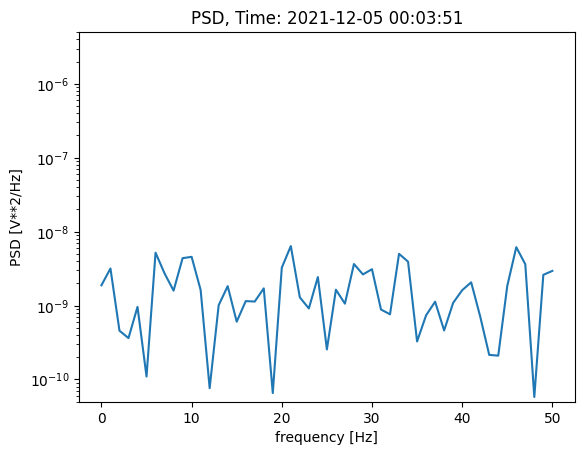

2021-12-05 00:03:52
2021-12-05 00:03:53


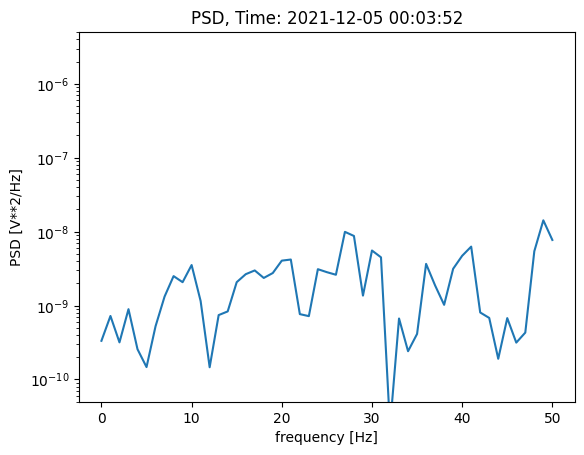

2021-12-05 00:03:53
2021-12-05 00:03:54


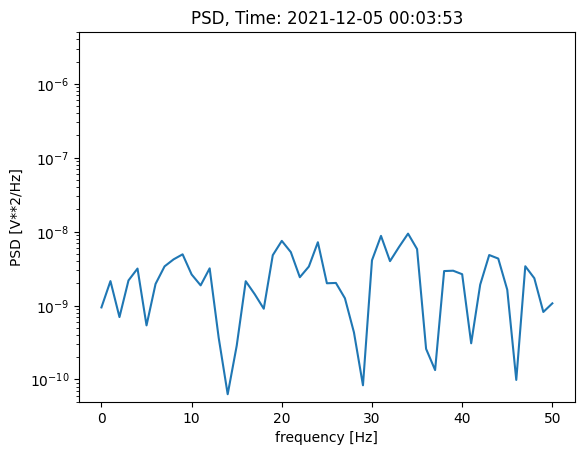

2021-12-05 00:03:54
2021-12-05 00:03:55


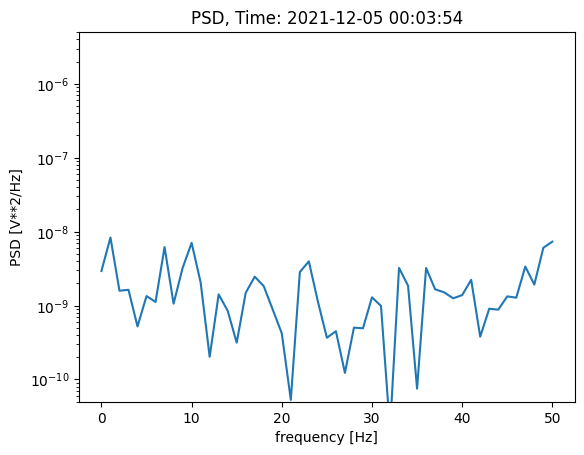

2021-12-05 00:03:55
2021-12-05 00:03:56


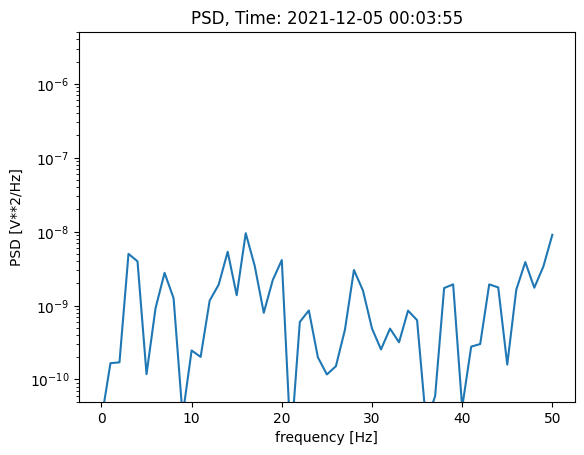

2021-12-05 00:03:56
2021-12-05 00:03:57


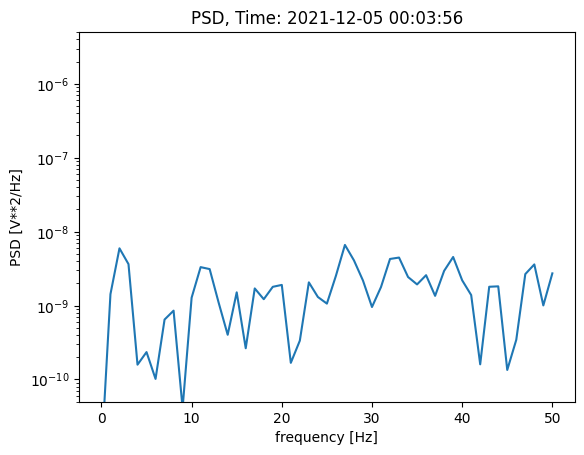

2021-12-05 00:03:57
2021-12-05 00:03:58


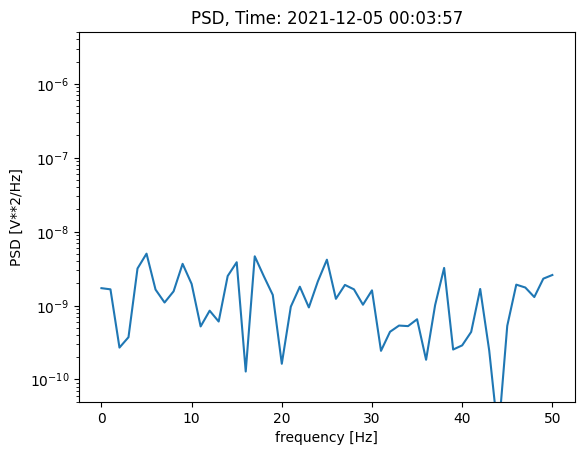

2021-12-05 00:03:58
2021-12-05 00:03:59


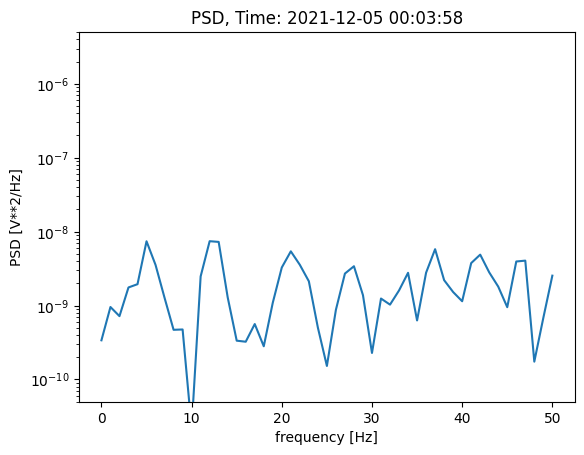

2021-12-05 00:03:59
2021-12-05 00:04:00


2021-12-05 00:04:00
2021-12-05 00:04:01


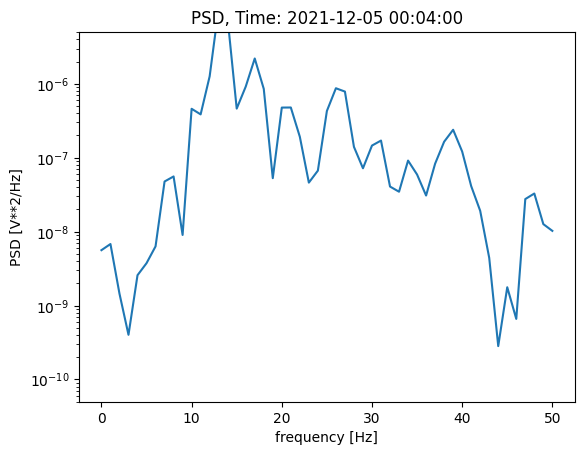

2021-12-05 00:04:01
2021-12-05 00:04:02


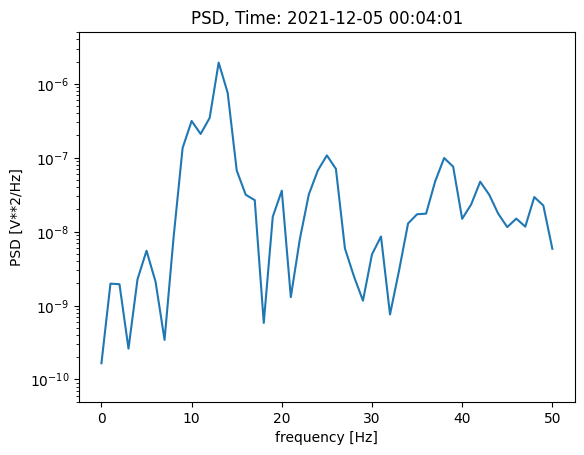

2021-12-05 00:04:02
2021-12-05 00:04:03


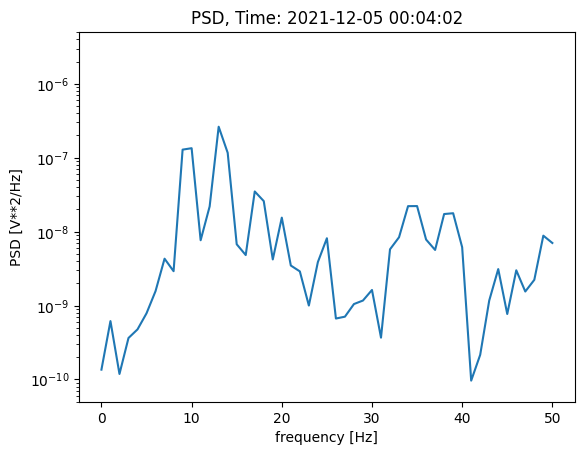

2021-12-05 00:04:03
2021-12-05 00:04:04


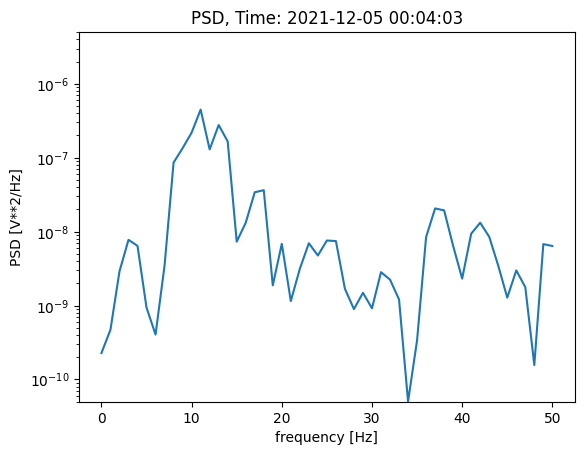

2021-12-05 00:04:04
2021-12-05 00:04:05


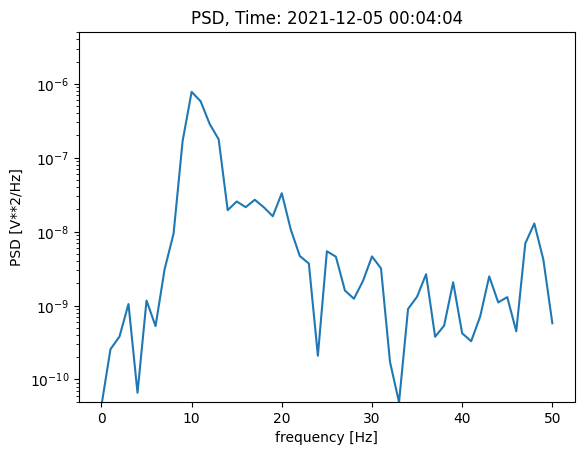

2021-12-05 00:04:05
2021-12-05 00:04:06


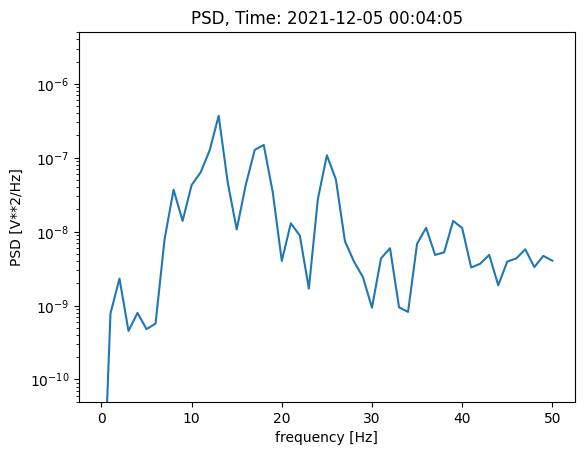

2021-12-05 00:04:06
2021-12-05 00:04:07


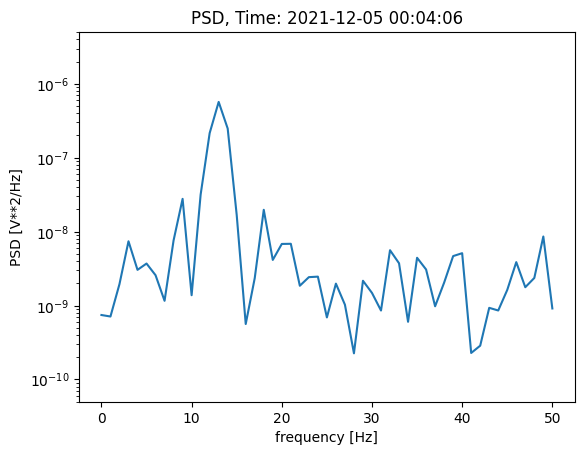

2021-12-05 00:04:07
2021-12-05 00:04:08


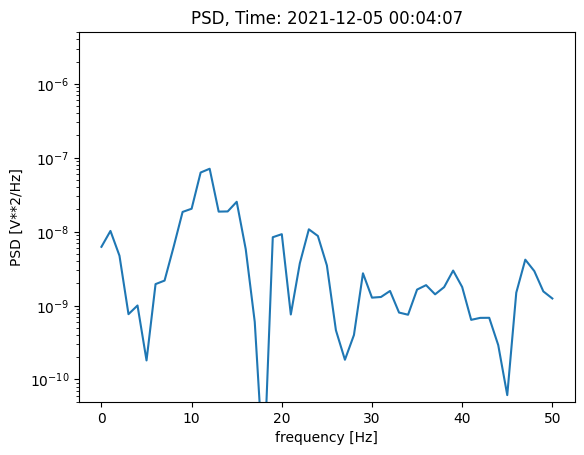

2021-12-05 00:04:08
2021-12-05 00:04:09


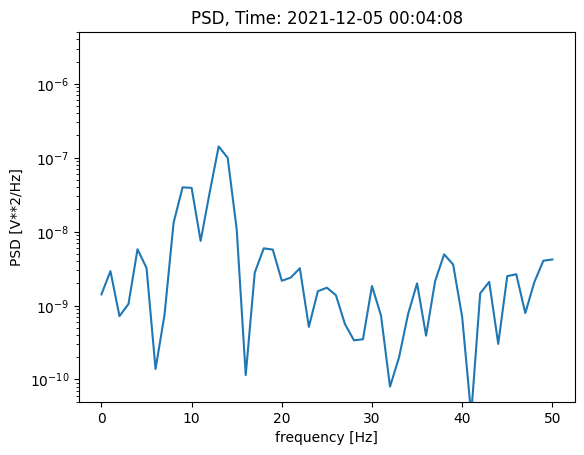

2021-12-05 00:04:09
2021-12-05 00:04:10


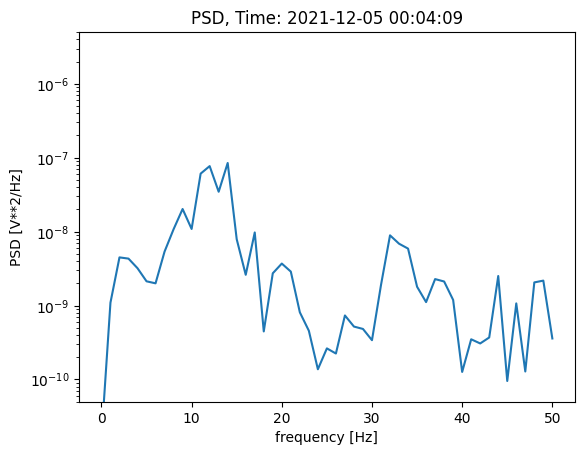

2021-12-05 00:04:10
2021-12-05 00:04:11


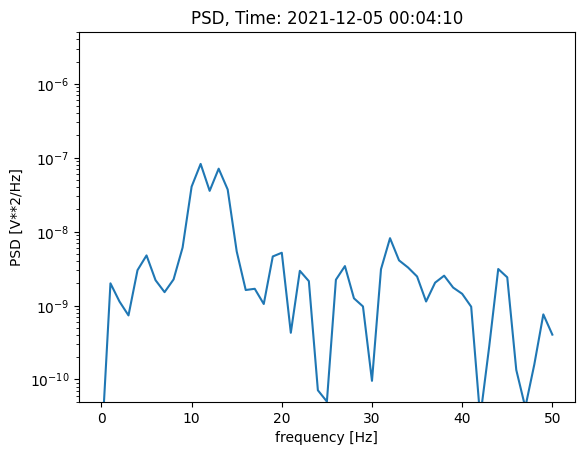

2021-12-05 00:04:11
2021-12-05 00:04:12


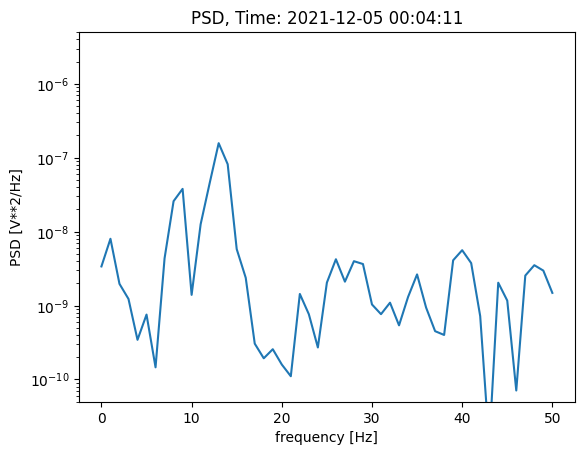

2021-12-05 00:04:12
2021-12-05 00:04:13


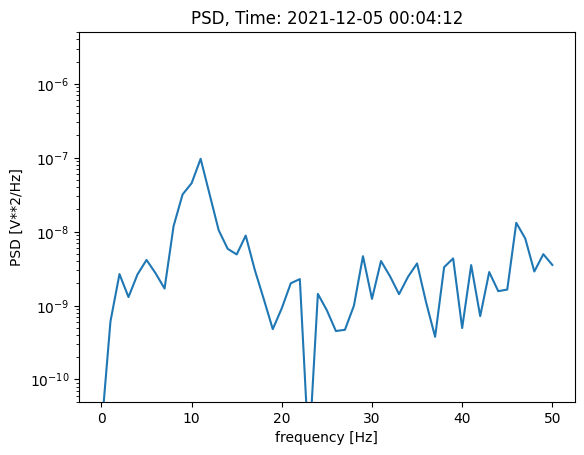

2021-12-05 00:04:13
2021-12-05 00:04:14


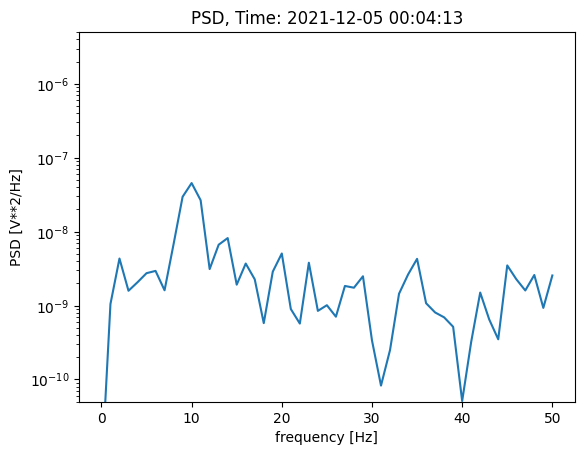

2021-12-05 00:04:14
2021-12-05 00:04:15


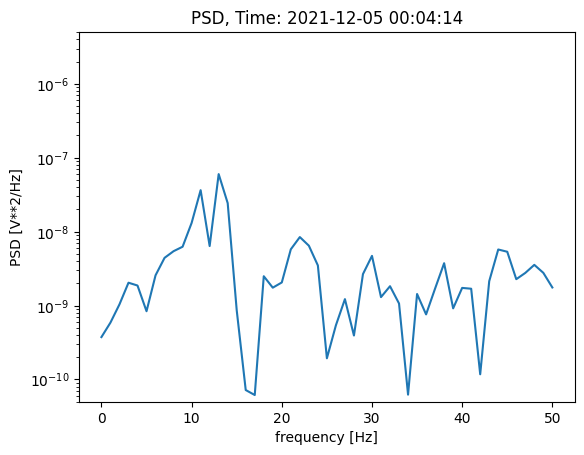

2021-12-05 00:04:15
2021-12-05 00:04:16


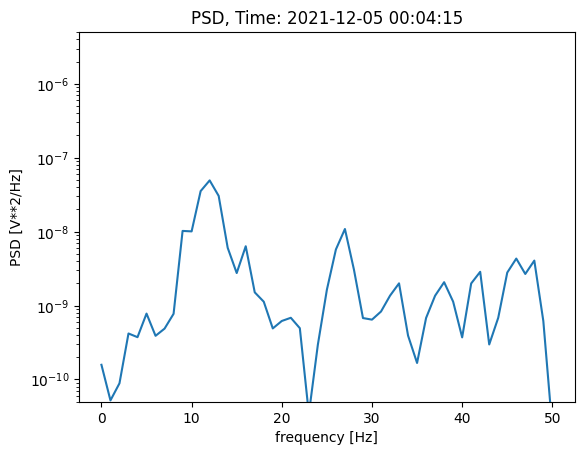

2021-12-05 00:04:16
2021-12-05 00:04:17


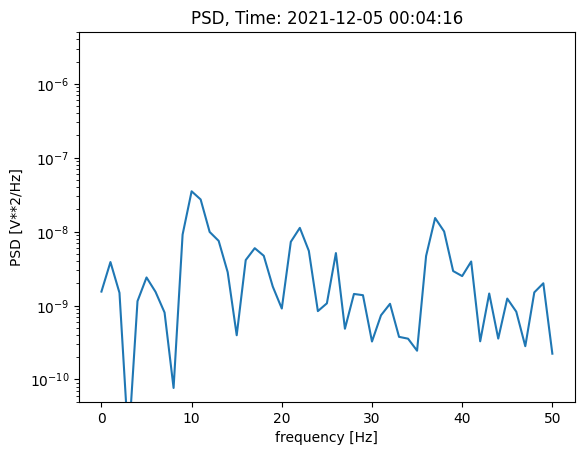

2021-12-05 00:04:17
2021-12-05 00:04:18


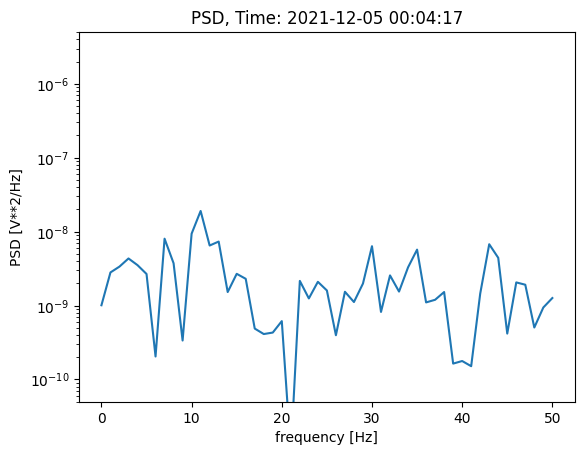

2021-12-05 00:04:18
2021-12-05 00:04:19


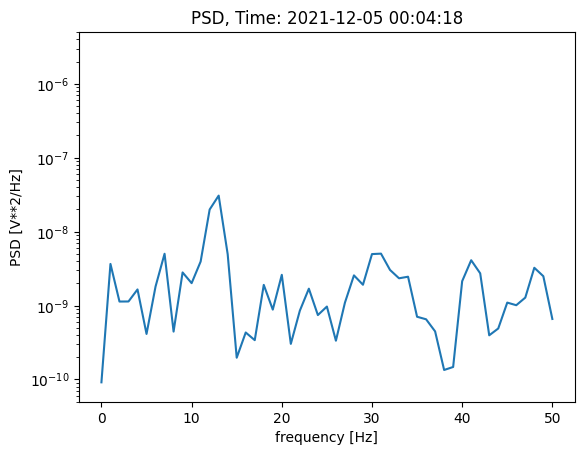

2021-12-05 00:04:19
2021-12-05 00:04:20


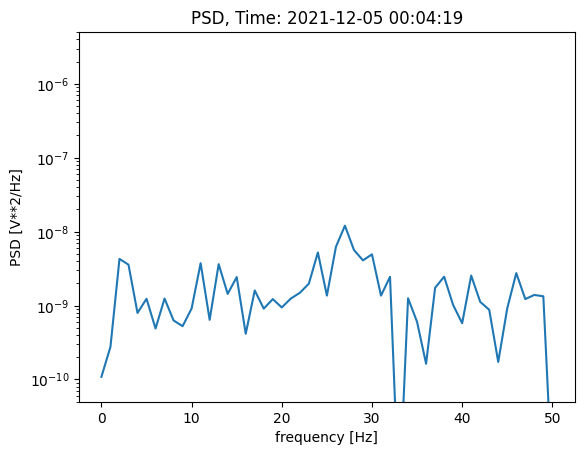

2021-12-05 00:04:20
2021-12-05 00:04:21


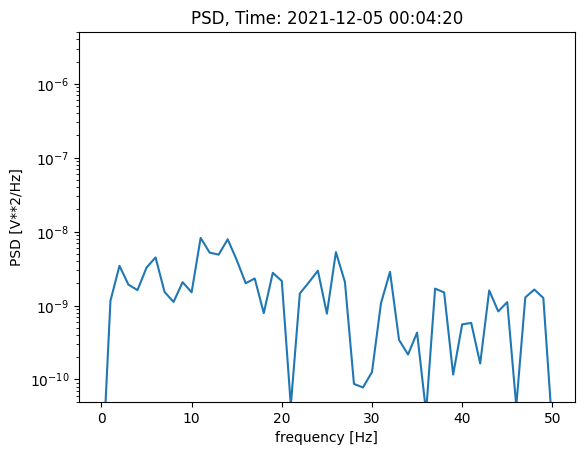

2021-12-05 00:04:21
2021-12-05 00:04:22


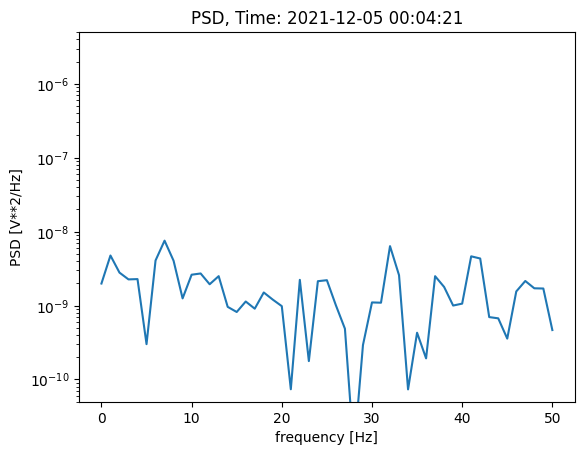

2021-12-05 00:04:22
2021-12-05 00:04:23


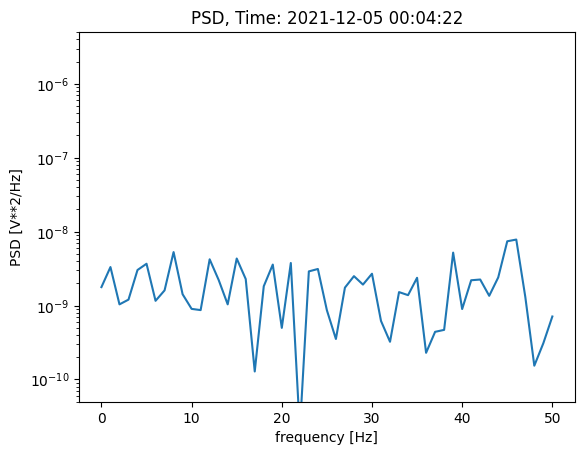

2021-12-05 00:04:23
2021-12-05 00:04:24


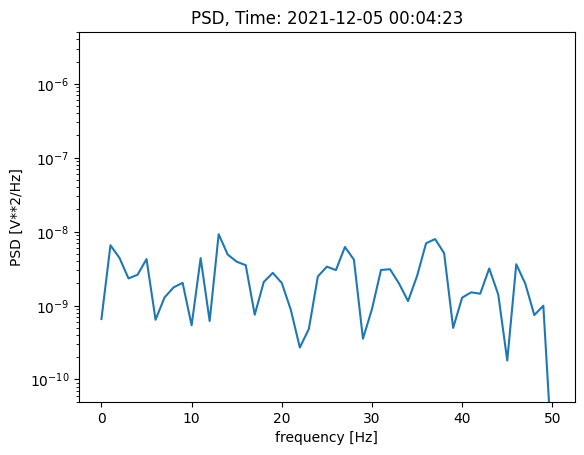

2021-12-05 00:04:24
2021-12-05 00:04:25


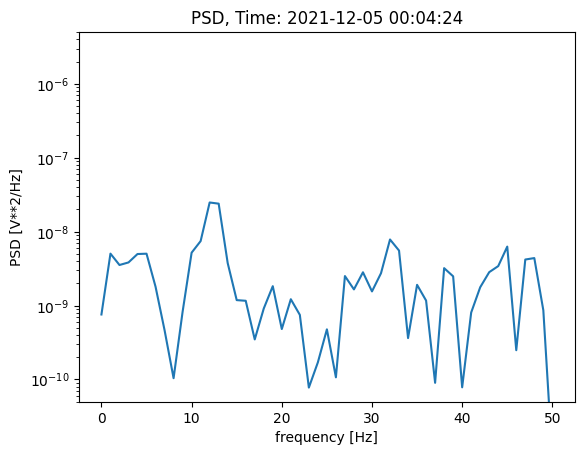

2021-12-05 00:04:25
2021-12-05 00:04:26


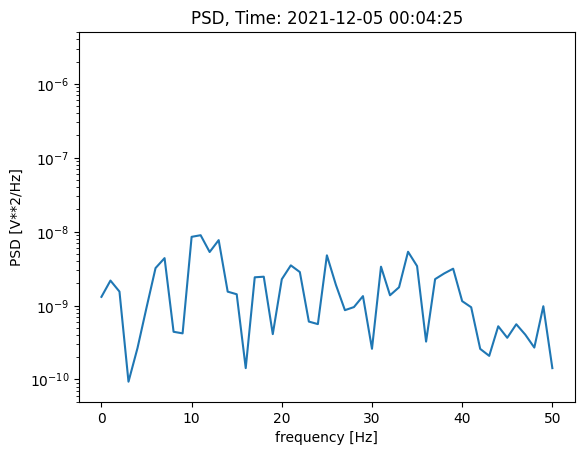

2021-12-05 00:04:26
2021-12-05 00:04:27


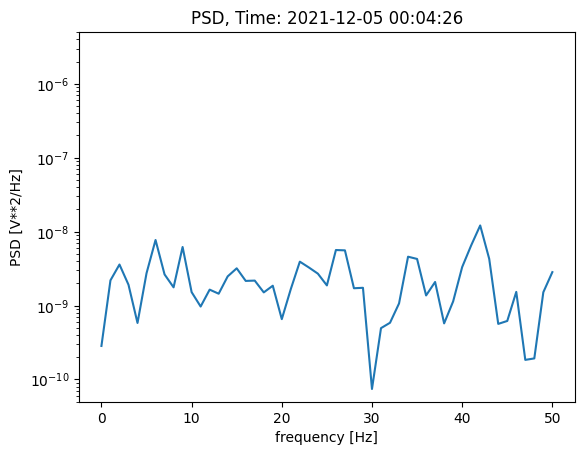

2021-12-05 00:04:27
2021-12-05 00:04:28


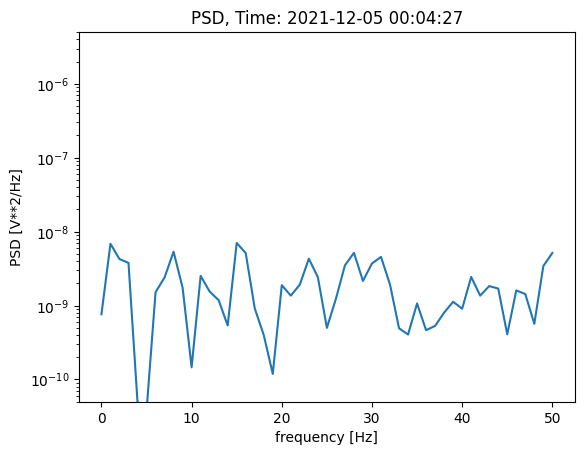

2021-12-05 00:04:28
2021-12-05 00:04:29


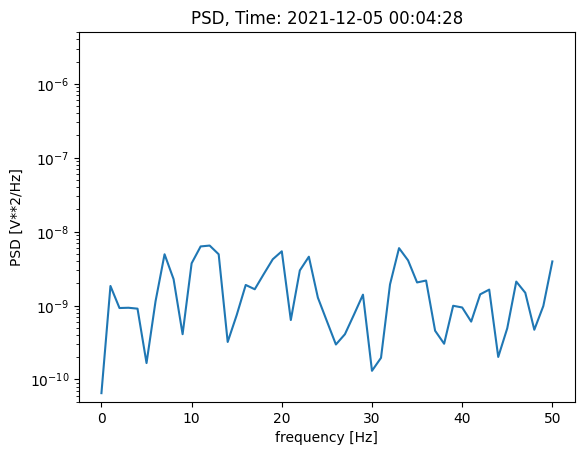

2021-12-05 00:04:29
2021-12-05 00:04:30


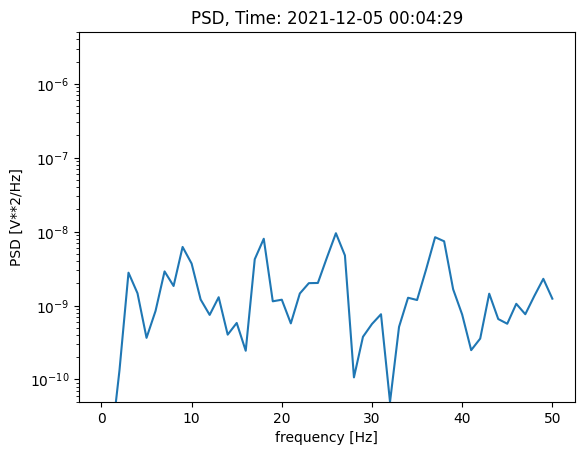

2021-12-05 00:04:30
2021-12-05 00:04:31


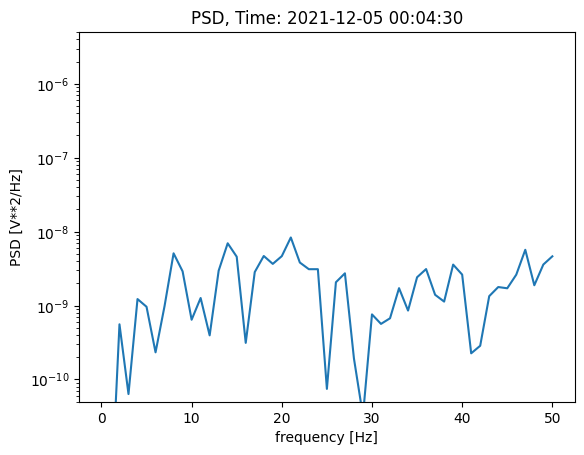

2021-12-05 00:04:31
2021-12-05 00:04:32


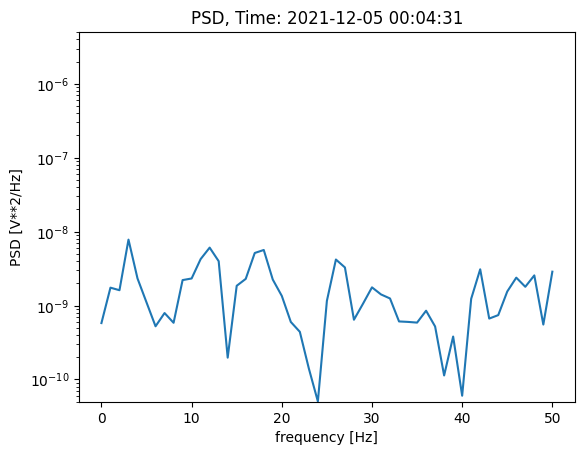

2021-12-05 00:04:32
2021-12-05 00:04:33


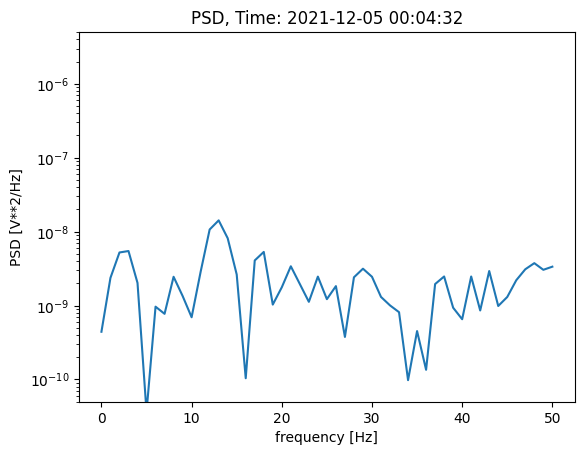

2021-12-05 00:04:33
2021-12-05 00:04:34


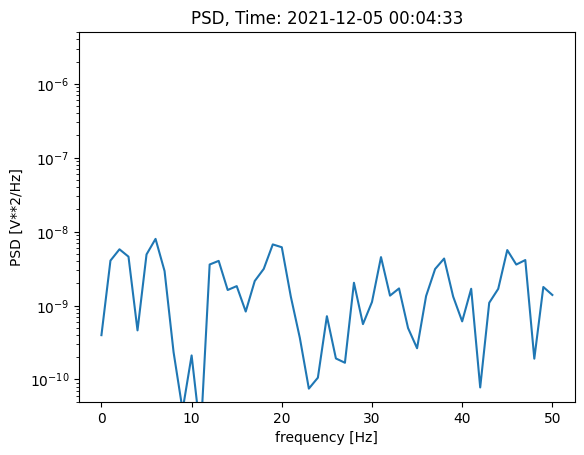

2021-12-05 00:04:34
2021-12-05 00:04:35


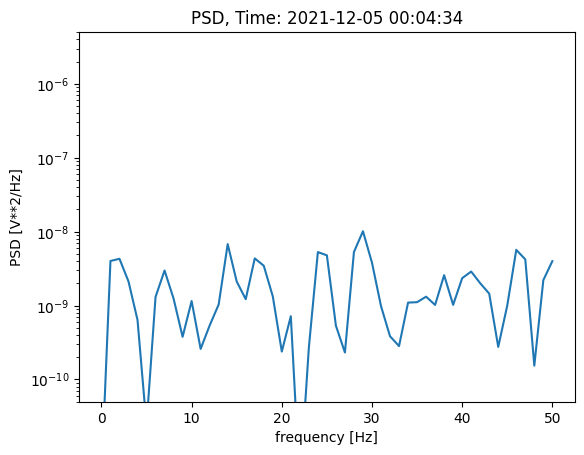

2021-12-05 00:04:35
2021-12-05 00:04:36


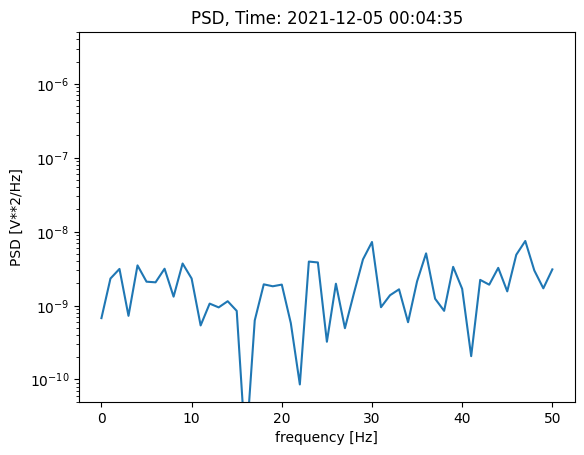

2021-12-05 00:04:36
2021-12-05 00:04:37


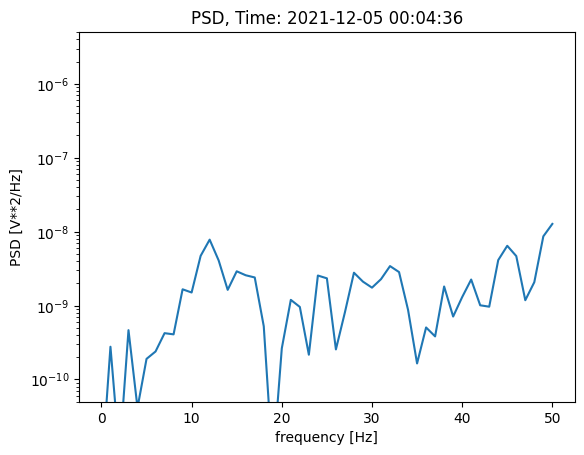

2021-12-05 00:04:37
2021-12-05 00:04:38


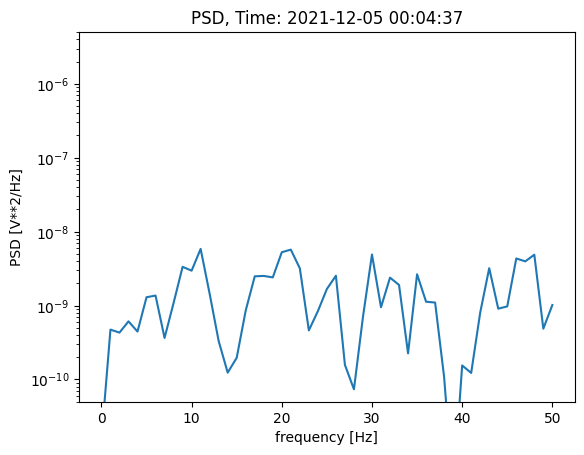

2021-12-05 00:04:38
2021-12-05 00:04:39


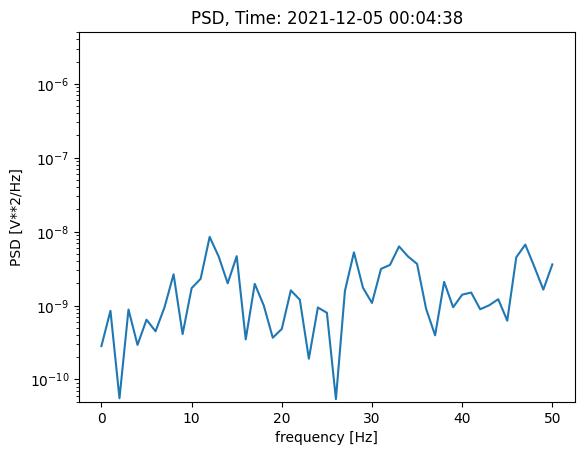

2021-12-05 00:04:39
2021-12-05 00:04:40


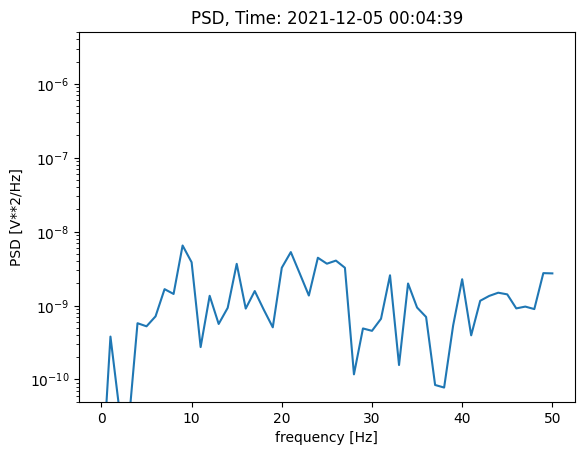

2021-12-05 00:04:40
2021-12-05 00:04:41


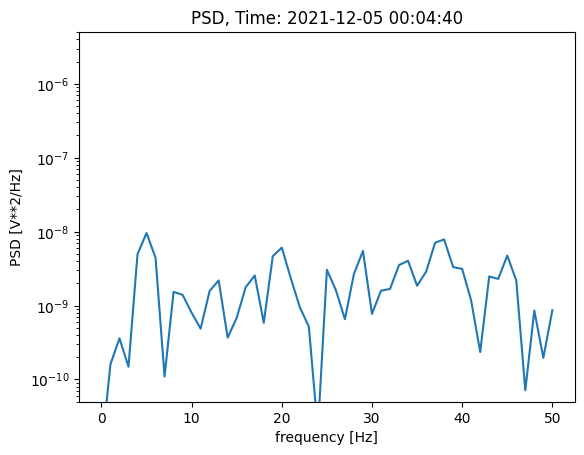

2021-12-05 00:04:41
2021-12-05 00:04:42


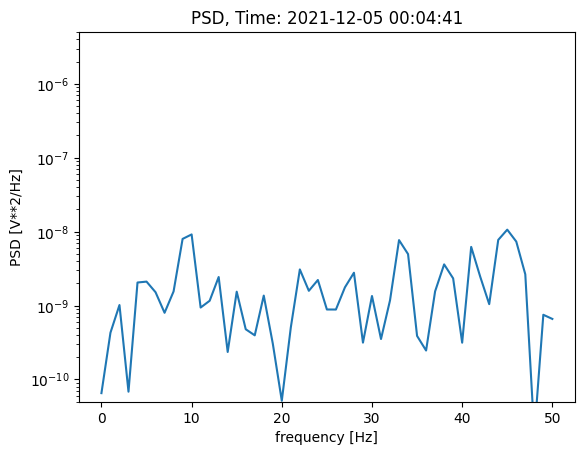

2021-12-05 00:04:42
2021-12-05 00:04:43


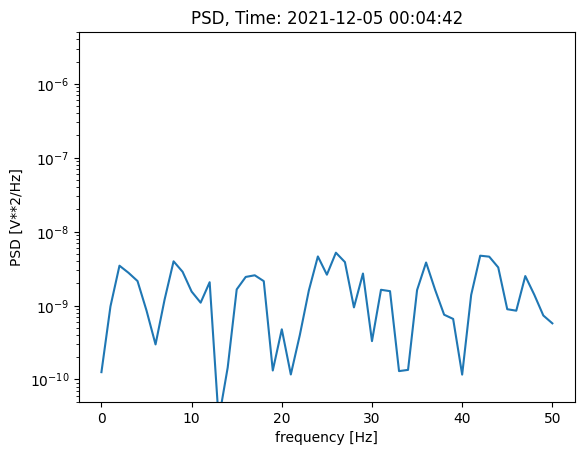

2021-12-05 00:04:43
2021-12-05 00:04:44


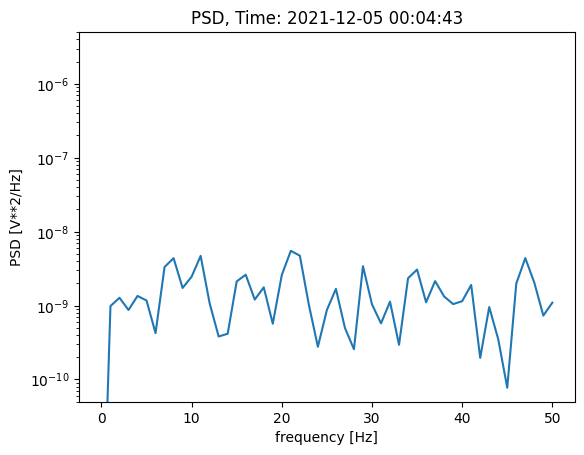

2021-12-05 00:04:44
2021-12-05 00:04:45


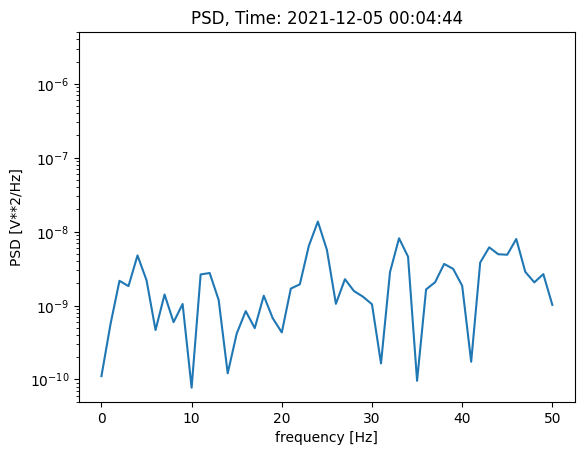

2021-12-05 00:04:45
2021-12-05 00:04:46


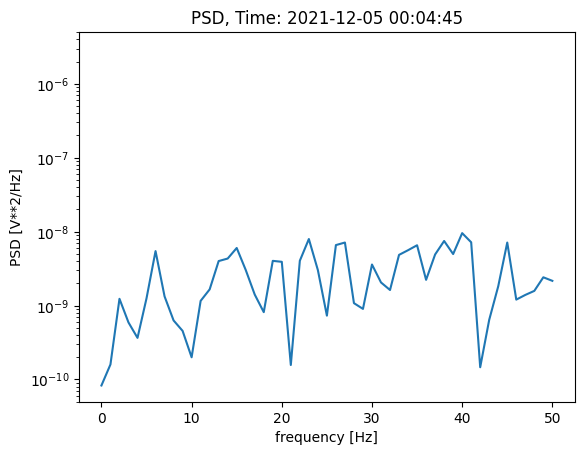

2021-12-05 00:04:46
2021-12-05 00:04:47


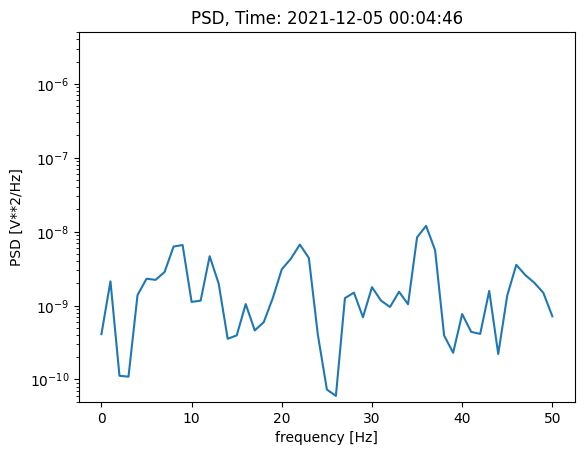

2021-12-05 00:04:47
2021-12-05 00:04:48


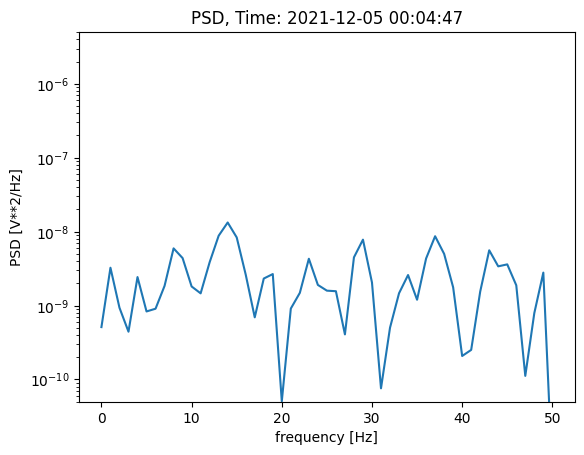

2021-12-05 00:04:48
2021-12-05 00:04:49


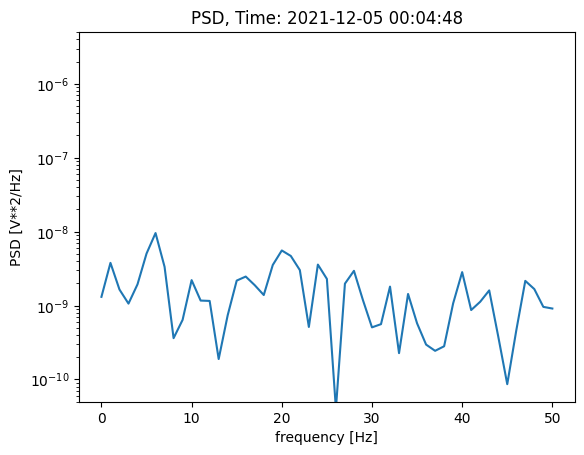

2021-12-05 00:04:49
2021-12-05 00:04:50


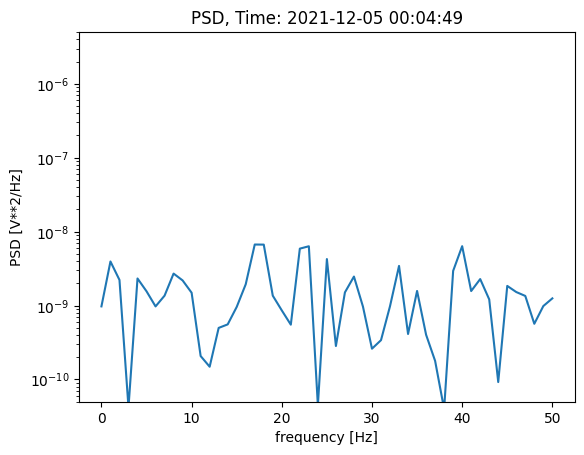

2021-12-05 00:04:50
2021-12-05 00:04:51


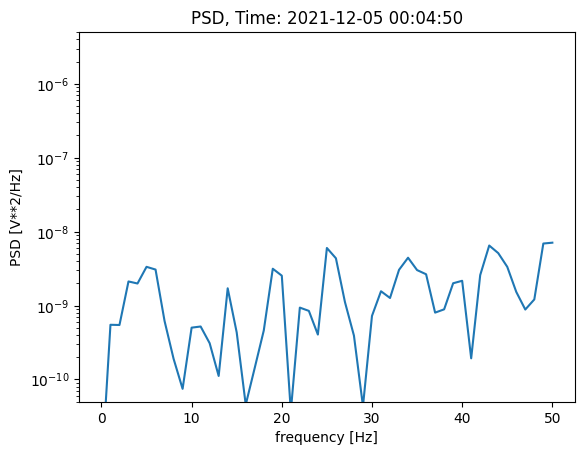

2021-12-05 00:04:51
2021-12-05 00:04:52


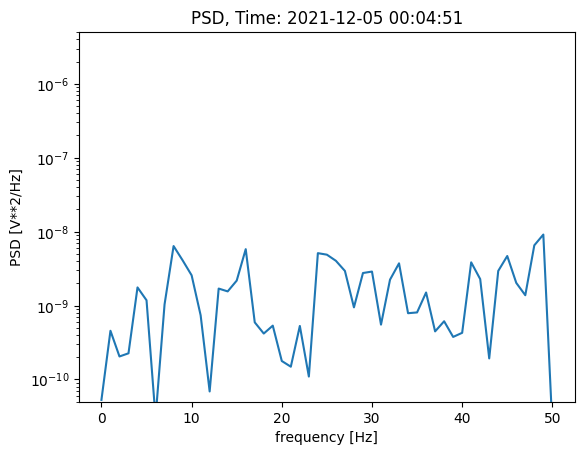

2021-12-05 00:04:52
2021-12-05 00:04:53


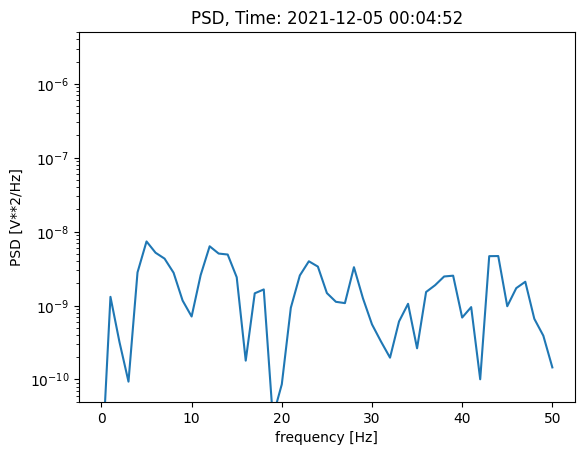

2021-12-05 00:04:53
2021-12-05 00:04:54


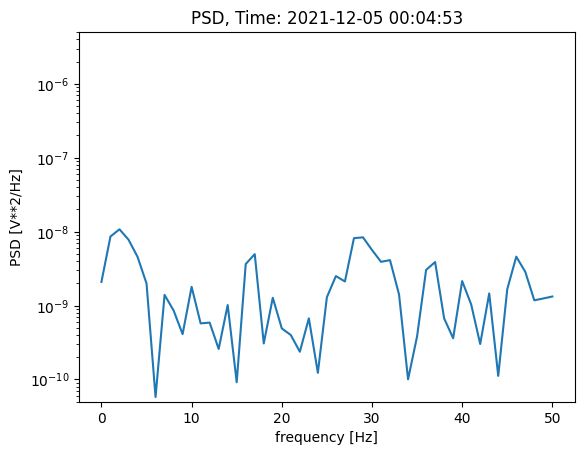

2021-12-05 00:04:54
2021-12-05 00:04:55


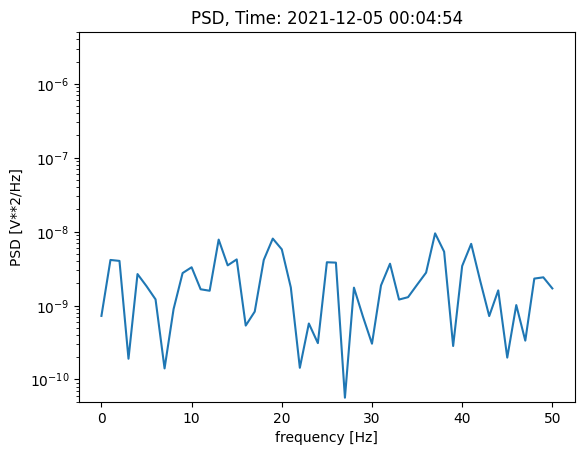

2021-12-05 00:04:55
2021-12-05 00:04:56


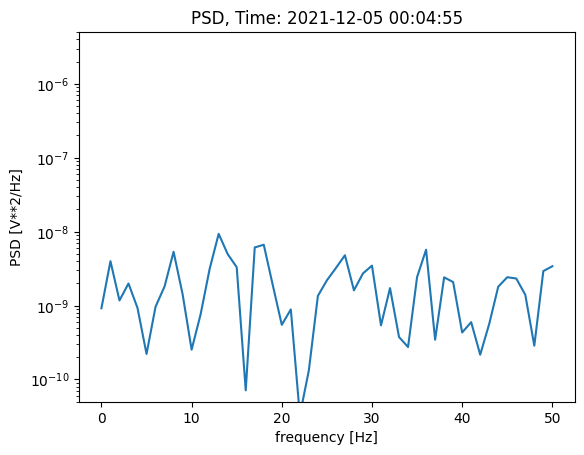

2021-12-05 00:04:56
2021-12-05 00:04:57


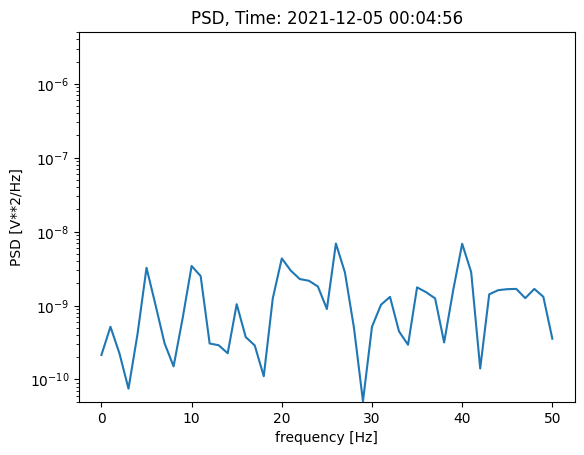

2021-12-05 00:04:57
2021-12-05 00:04:58


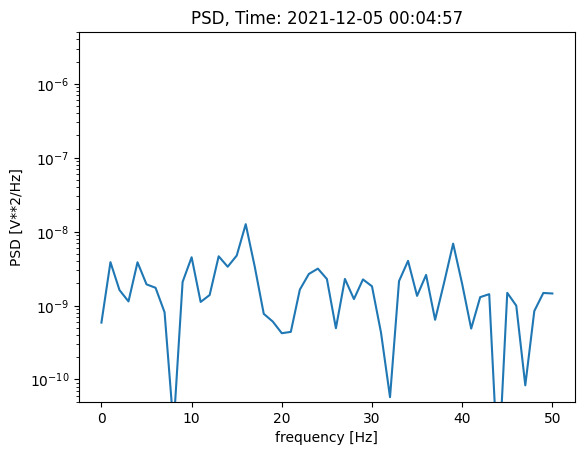

2021-12-05 00:04:58
2021-12-05 00:04:59


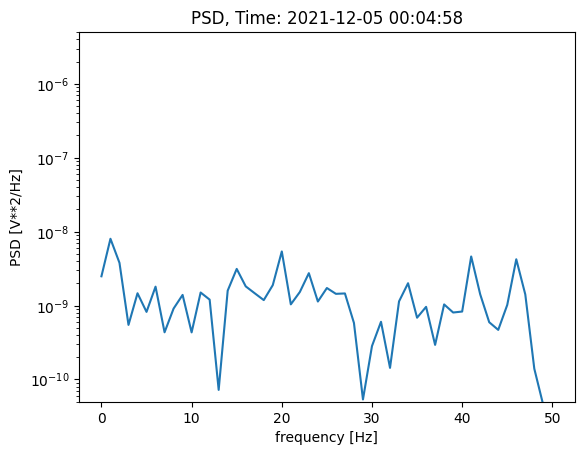

2021-12-05 00:04:59
2021-12-05 00:05:00


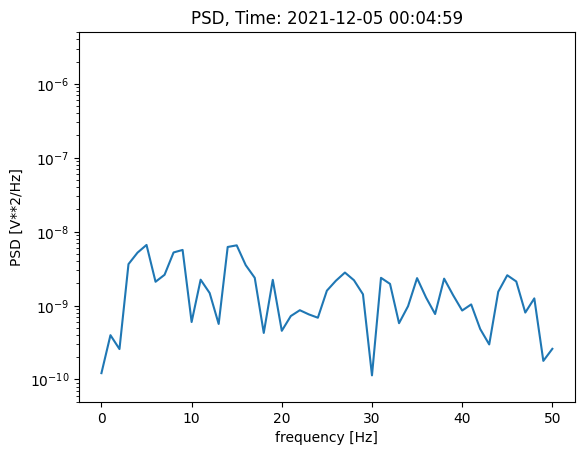

In [35]:
start_date_str = '2021-12-05 00:03:00'
start_date = datetime.strptime(start_date_str, '%Y-%m-%d %H:%M:%S')
end_date = start_date + timedelta(0,1)
for i in range(120):
    start_date_str = start_date.strftime('%Y-%m-%d %H:%M:%S')
    print(start_date_str)
    end_date_str = end_date.strftime('%Y-%m-%d %H:%M:%S')
    print(end_date_str)
    slice = data[(data["ts"]>= start_date_str) & (data["ts"]<= end_date_str)]

    printPSD(slice["z2"], start_date_str)

    start_date = start_date + timedelta(0,1)
    end_date = start_date + timedelta(0,1)

In [ ]:
end_date.strftime('%Y-%m-%d %H:%M:%S')